In [1]:
import numpy as np
import gym
import tensorflow as tf
from baselines.common.vec_env.subproc_vec_env import SubprocVecEnv
from baselines.common.vec_env.dummy_vec_env import DummyVecEnv

learning_rate = 5e-4
epochs_number = 10000
batch_size = 32
replay_buffer_size = 32
l2_regularization = 0

env_name = 'BipedalWalker-v2'
environments_count = 24

# This code gets action and observation space sizes for 1D tasks
env = gym.make(env_name)
action_space = env.action_space.n if isinstance(env.action_space, gym.spaces.discrete.Discrete) else env.action_space.shape[0]
observation_space = env.observation_space.n if isinstance(env.observation_space, gym.spaces.discrete.Discrete) else env.observation_space.shape[0]


## Create environments vector

In [2]:
def make_env(env_id, seed):
    def _f():
        env = gym.make(env_id)
        env.seed(seed)
        
        # Desync environments
        env.reset()
        for i in range(int(env.spec.max_episode_steps*seed//environments_count)):
            env.step(env.action_space.sample())
        return env
    return _f

envs = [make_env(env_name, seed) for seed in range(environments_count)]
envs = DummyVecEnv(envs)

## Define model architecture

In [3]:
epsilon = 1e-8

def gaussian_loglikelihood(x, mu, log_std):
    pre_sum = -0.5 * (((x - mu) / (tf.exp(log_std) + epsilon))**2 + 2 * log_std + np.log(2 * np.pi))
    return tf.reduce_sum(pre_sum, axis=1)

In [4]:
tf.reset_default_graph()

class ActorNetwork:
    def __init__(self, )
    state_ph = tf.placeholder(tf.float32, shape=[None, observation_space])

    l1 = tf.layers.dense(state_ph, units=32, activation=tf.nn.relu)
    mu = tf.layers.dense(l1, units=action_space)

    log_std = tf.get_variable(name='log_std', initializer=-0.5 * np.ones(action_space, dtype=np.float32))
    std = tf.exp(log_std)

    action_op = mu + tf.random.normal(shape=tf.shape(mu)) * std


    # Training
    weight_ph = tf.placeholder(shape=[None], dtype=tf.float32)
    action_ph = tf.placeholder(shape=[None, action_space], dtype=tf.float32)

    action_logprob = gaussian_loglikelihood(action_ph, mu, log_std)
    test_debug = (action_ph - mu)**2

    all_params = tf.trainable_variables() 
    loss_l2 = tf.add_n([ tf.nn.l2_loss(v) for v in all_params ]) * l2_regularization

    loss = -tf.reduce_mean(action_logprob * weight_ph) + loss_l2
    gradients = tf.gradients(loss, tf.trainable_variables()) # For debug

    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    update = optimizer.minimize(loss)
    
    
class CriticNetwork:
    state_ph = tf.placeholder(tf.float32, shape=[None, observation_space])

    l1 = tf.layers.dense(state_ph, units=32, activation=tf.nn.relu)
    mu = tf.layers.dense(l1, units=action_space)

    log_std = tf.get_variable(name='log_std', initializer=-0.5 * np.ones(action_space, dtype=np.float32))
    std = tf.exp(log_std)

    action_op = mu + tf.random.normal(shape=tf.shape(mu)) * std


    # Training
    weight_ph = tf.placeholder(shape=[None], dtype=tf.float32)
    action_ph = tf.placeholder(shape=[None, action_space], dtype=tf.float32)

    action_logprob = gaussian_loglikelihood(action_ph, mu, log_std)
    test_debug = (action_ph - mu)**2

    all_params = tf.trainable_variables() 
    loss_l2 = tf.add_n([ tf.nn.l2_loss(v) for v in all_params ]) * l2_regularization

    loss = -tf.reduce_mean(action_logprob * weight_ph) + loss_l2
    gradients = tf.gradients(loss, tf.trainable_variables()) # For debug

    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    update = optimizer.minimize(loss)
    

W0716 15:52:11.929486 20536 deprecation.py:323] From <ipython-input-4-e0f14cb426ef>:12: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0716 15:52:11.935470 20536 deprecation.py:506] From C:\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0716 15:52:12.221706 20536 deprecation.py:323] From C:\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [5]:
config = tf.ConfigProto(device_count={'GPU': 0})
sess = tf.Session(config=config)

sess.run(tf.local_variables_initializer())
sess.run(tf.global_variables_initializer())

# sess.run(loss, feed_dict={weight_ph: [0, 1, 2],
#                           action_ph: [1, 2, 3],
#                           state_ph: [[1,2], [1,2], [1,2]]})

In [6]:
def make_reward_to_go(reward):
    return np.cumsum(reward[::-1])[::-1]

make_reward_to_go(np.arange(1, 5))

array([10,  9,  7,  4], dtype=int32)

#TODO: подумать о последствиях слишком большого количества сэмплов в начале (решил рассинхронизацией)

In [7]:
def generate_batch(envs, batch_size, replay_buffer_size):
    envs_number = envs.num_envs
    observations = [[0 for i in range(observation_space)] for i in range(envs_number)]
    replay_buffer = np.empty((0,3), np.float32)
    
    # [state, action, weight] rollout lists for every environment instance
    rollouts = [np.empty((0, 3)) for i in range(envs_number)]

    while True:
        history = {'reward': [], 'max_action': []}
        replay_buffer = replay_buffer[batch_size:]
        
        # Main sampling cycle
        while len(replay_buffer) < replay_buffer_size:
            actions = sess.run(action_op, feed_dict={state_ph: observations})
            observations_old = observations
            observations, rewards, dones, _ = envs.step(actions)
            
            history['max_action'].append(np.abs(actions).max())
            
            time_point = np.array(list(zip(observations_old, actions, rewards)))
            for i in range(envs_number):
                rollouts[i] = np.append(rollouts[i], [time_point[i]], axis=0) # Regular python append
            
            if dones.any():
                if dones.all():
                    print('WARNING: envs are in sync!!')
                
                done_indexes = np.arange(envs_number)[dones]
                for i in done_indexes:
                    #print(dones, i, len(rollouts[i][:, 2]))
                    history['reward'].append(rollouts[i][:, 2].sum())

                    rollouts[i][:, 2] = make_reward_to_go(rollouts[i][:, 2])
                    replay_buffer = np.append(replay_buffer, rollouts[i], axis=0)
                    rollouts[i] = np.empty((0, 3))
                #history['reward'] = [np.mean(history['reward'])]
        
        np.random.shuffle(replay_buffer)
        replay_buffer = replay_buffer[:replay_buffer_size] ### QUESTIONABLE
        yield replay_buffer[:batch_size], history

a = generate_batch(envs, 8, 64)
# Makes them of equal lenght
for i in range(10):
    next(a)
next(a)[0]

array([[array([ 1.006674  ,  0.04161604, -0.0299828 , -0.04951331, -0.7175731 ,
        0.37998322,  0.93524015,  0.        ,  0.        ,  1.1052227 ,
       -0.22209989,  0.93442845,  0.        ,  0.        ,  0.45193088,
        0.45706323,  0.4730594 ,  0.50189614,  0.5475723 ,  0.61765444,
        0.7270329 ,  0.9082741 ,  1.        ,  1.        ], dtype=float32),
        array([-1.0745206 ,  0.26531816, -0.84056675,  0.49224383], dtype=float32),
        -105.607056],
       [array([ 5.4301787e-02, -4.0061940e-03,  3.1292919e-02,  1.9009255e-02,
       -8.0539161e-01, -6.4527057e-02,  2.5267798e-01,  1.3633715e-01,
        1.0000000e+00,  1.1303291e+00, -8.1956387e-07,  9.3199909e-01,
       -3.0315507e-03,  1.0000000e+00,  2.2480099e-01,  2.2735393e-01,
        2.3531079e-01,  2.4965486e-01,  2.7237523e-01,  3.0723575e-01,
        3.6164314e-01,  4.5179361e-01,  6.1873162e-01,  9.8800939e-01],
      dtype=float32),
        array([1.1000533 , 0.29449326, 1.0155095 , 0.55138314], d

## Train agent 

In [8]:
from tqdm import tqdm_notebook

history = {'reward': [], 'loss': [], 'gradients_max_abs': [], 'gradients_equal_zero': [], 'max_action': []}
batch_generator = generate_batch(envs,
                                 batch_size=batch_size,
                                 replay_buffer_size=replay_buffer_size)

saver = tf.train.Saver()


# Makes them of equal lenght
print('Charging generators')
for i in range(20):
    next(batch_generator)

max_value = -70

for epoch in tqdm_notebook(range(epochs_number)):
    batch, batch_history = next(batch_generator)
    history['reward'] += batch_history['reward']
    history['max_action'] += batch_history['max_action']

    value = int(np.mean(history["reward"][-10:]))
    if max_value < value:
        save_path = saver.save(sess, f'./models/{env_name}-reward-{value}.ckpt')
        print("Model saved in path: %s" % save_path)
        max_value = value

#     print(np.array(batch[:, 1].tolist()))
#     print(batch[:, 1].tolist())

#     arr = sess.run([log_std, std, action_logprob, action_op, mu, action_ph, test_debug], feed_dict={
#                                                     state_ph: np.array(batch[:, 0].tolist()),
#                                                     action_ph: np.array(batch[:, 1].tolist()),
#                                                     weight_ph: batch[:, 2]})

#     for k, name in zip(arr, ['log_std', 'std', 'action_logprob', 'action_op', 'mu', 'action_ph', 'test_debug']):
#         print(k[0], name)
#     #print(np.exp(e))
#     print(f'--------- {epoch} ------------')


    _, loss_, gradients_, mu_ = sess.run([update, loss, gradients, action_ph], feed_dict={
                                                    state_ph: np.array(batch[:, 0].tolist()),
                                                    action_ph: np.array(batch[:, 1].tolist()),
                                                    weight_ph: batch[:, 2]})

    
    history['gradients_max_abs'].append(np.max([np.max(np.abs(var_grad)) for var_grad in gradients_]))
    history['gradients_equal_zero'].append(np.sum([np.sum(var_grad == 0) for var_grad in gradients_]))    
    history['loss'].append(loss_)


Charging generators


Model saved in path: ./models/BipedalWalker-v2-reward--52.ckpt


KeyboardInterrupt: 

Learning rate - очень чувствительный 1e-3 - не учится (взрывается до +беск), 1e-4 не сходится, 3e-4 ОК



Похоже, что policy gradient должен иметь как можно более быстрый отклик от среды, иначе мы штрафуем его за действия из другого распределения, а их логарифм равен 0

Кажется, теперь понятно зачем нужны trust region'ы - без них что-то происходит и policy умирает


## Plot results

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

# Moving average
def smoothen_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points


def plot(array, title='', axis=plt):
    axis.title.set_text(title)
    axis.plot(np.arange(len(array)), smoothen_curve(array))    

Text(0.5, 0.98, 'BipedalWalker-v2')

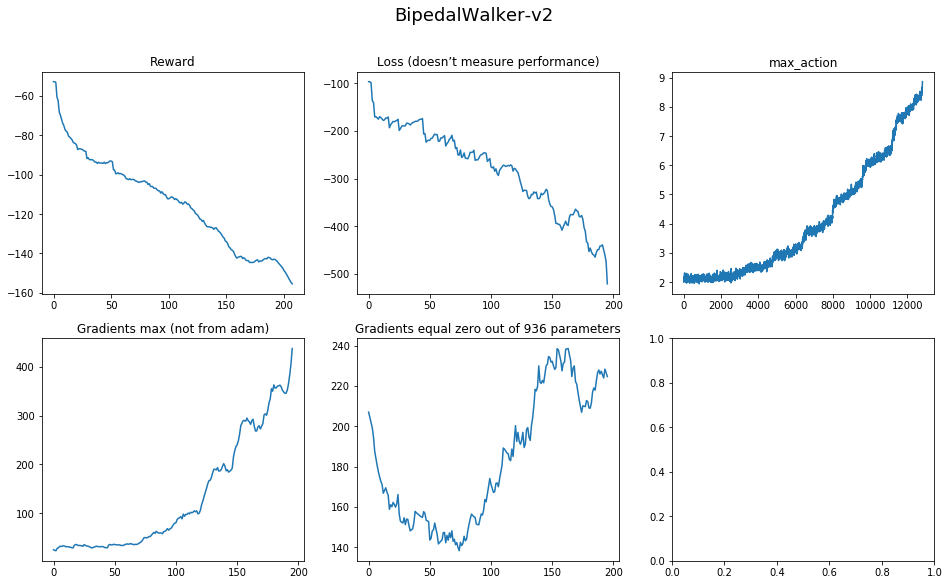

In [10]:
fig, axs = plt.subplots(2, 3, figsize=(16, 9))
plot(history['reward'], 'Reward', axs[0, 0])
plot(history['loss'], 'Loss (doesn’t measure performance)', axs[0, 1])
plot(history['gradients_max_abs'], 'Gradients max (not from adam)', axs[1, 0])


parameters_number = np.sum([np.ones_like(g).sum() for g in gradients_])
plot(history['gradients_equal_zero'], f'Gradients equal zero out of {int(parameters_number)} parameters', axs[1, 1])

plot(history['max_action'], 'max_action', axs[0, 2])
plt.suptitle(env_name, fontsize=18)

#plt.savefig('logs/LunarLanderContinuous-v2_fail')

## Our agent

In [ ]:
observations = env.reset()

for i in range(10000):
    env.render()
    actions = sess.run(action_op, feed_dict={state_ph: [observations]})
    
    
    observations_old = observations
    observations, rewards, dones, _ = env.step(actions[0])

    print(rewards, actions[0])


    if dones:
        observations = env.reset()
        print('Done')


## Random agent

In [ ]:
observations = env.reset()

for i in range(1000):
    env.render()
    actions = [envs.action_space.sample() for i in range(envs.num_envs)]
    
    
    observations_old = observations
    observations, rewards, dones, _ = env.step(actions[0])
    print(rewards, actions[0])
    
    if dones:
        observations = env.reset()
        print('Done')
    

In [ ]:
import time
saver = tf.train.Saver()
#save_path = saver.save(sess, f'./models/{env_name}-reward-{int(np.mean(history["reward"][-50:]))}.ckpt')
print("Model saved in path: %s" % save_path)

In [ ]:
# saver = tf.train.Saver()
# saver.restore(sess, "./models/LunarLanderContinuous-v2-reward-96.ckpt")